# MobileNet-v1-224px - Data Augmentation

## Activa GPU rey, desde notebooks settings

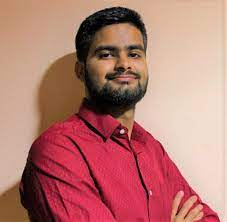

## Librerias

Instalar roboflow e importar el resto de las librerias.

Tip: luego de correr pip install roboflow, apretar en la cruz que sale para ocultar el output horrible.

In [ ]:
!pip install roboflow

In [ ]:
import numpy as np
import cv2
from keras.applications.mobilenet import MobileNet
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from keras.optimizers import Adam
from keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
import pandas as pd
from roboflow import Roboflow
from keras import callbacks
from google.colab.patches import cv2_imshow

## RoboFlow

Importar datos utilizando la API de roboflow: esto viene del export que sale de RoboFlow, seleccionando metodo de export "code" y "multiclass"

In [ ]:
rf = Roboflow(api_key="RIRyho5TtyNxqxJqhn2s")
project = rf.workspace("fall-detection-nzoyh").project("fall-detection-bb")
dataset = project.version(4).download("multiclass")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to fall-detection-bb-4 in multiclass:: 100%|██████████| 2248/2248 [00:01<00:00, 1790.58it/s]


Guardamos la version

In [ ]:
version = int(dataset.version)
version

4

Funcion **move to folder**:

Generar las carpetas fall y no fall y meter las imagenes donde correspondan segun lo que dicen los CSV

In [ ]:
import os
import shutil
import pandas as pd

def move_to_folders(version, folder):
  # Define the paths
  image_folder = f"/content/fall-detection-bb-{version}/{folder}"
  csv_file = f"/content/fall-detection-bb-{version}/{folder}/_classes.csv"
  output_folder = f"/content/fall-detection-bb-{version}/{folder}"

  # Read the CSV file
  data = pd.read_csv(csv_file)
  data['label'] = ['fall' if x == 1 else 'no fall' for x in data[' fall']]

  # Create folders for each label
  for label in ["fall", "no fall"]:
      folder_path = os.path.join(output_folder, label)
      os.makedirs(folder_path, exist_ok=True)

  # Move images to their corresponding folders
  for index, row in data.iterrows():
      image_name = row["filename"]
      label = row["label"]

      source_path = os.path.join(image_folder, image_name)
      destination_folder = os.path.join(output_folder, label)
      destination_path = os.path.join(destination_folder, image_name)

      # Move the image to the destination folder
      shutil.move(source_path, destination_path)

  print("Images moved successfully!")

Luego de correr esto, comprobar que en cada carpeta de train, test y valid ahora hay dos carpetas dentro, fall y no fall.

In [ ]:
move_to_folders(version,'train')
move_to_folders(version,'valid')
move_to_folders(version,'test')

Images moved successfully!
Images moved successfully!
Images moved successfully!


## Data Prep for Model

No hace falta tocar nada.

Lo que hace este paso es generar el formato dataset que luego tomara el modelo para entrenar y predecir.

In [ ]:
# Rutas de las carpetas de entrenamiento, validación y prueba
train_dir = f'/content/fall-detection-bb-{version}/train'
valid_dir = f'/content/fall-detection-bb-{version}/valid'
test_dir = f'/content/fall-detection-bb-{version}/test'

# Tamaño de redimensionamiento deseado
target_size = (224, 224)

# Definir la transformación de datos para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalizar los valores de píxeles a [0, 1]
    preprocessing_function=lambda x: cv2.resize(x, target_size)
)

# Definir la transformación de datos para el conjunto de validación y prueba
valid_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda x: cv2.resize(x, target_size)
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda x: cv2.resize(x, target_size)
)

# Crear generadores de datos a partir de las carpetas
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,  # Tamaño de las imágenes de entrada
    batch_size=32,  # Tamaño del lote (batch)
    class_mode='binary', # Modo de clasificación (categórica en este caso)
    classes = ['no fall','fall'],
    shuffle=False
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='binary',
    classes = ['no fall','fall'],
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='binary',
    classes = ['no fall','fall'],
    shuffle=False
)

Found 2034 images belonging to 2 classes.
Found 133 images belonging to 2 classes.
Found 73 images belonging to 2 classes.


In [ ]:
test_generator.class_indices

{'no fall': 0, 'fall': 1}

## Define model

En este ejemplo cargamos el modelo MobileNet, con los pesos del dataset imagenet.

In [ ]:
def load_MobileNet():
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

  for layer in base_model.layers:
    layer.trainable = False

  return base_model

base_model = load_MobileNet()

17225924/17225924 [==============================] - 2s 0us/step


Numero de clases: no tocar, estmaos haciendo binario

Capas densas, se puede tocar si se quiere

In [ ]:
num_classes = 2

model = Sequential()
model.add(base_model)

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

Compilar.

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='binary_crossentropy',
                     metrics=[tf.keras.metrics.AUC()])

Visualizar

In [ ]:
plot_model(model)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 128)               6422656   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                        

Preparamos todo para poder guardar el mejor modelo en drive. Darle OK cuando te salte la ventana emergente.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
if not os.path.isdir('/content/gdrive/MyDrive/bestmodels'):
  print('creando best model para vos bebe')
  os.makedirs('/content/gdrive/MyDrive/bestmodels')
else:
  print('ya existe la carpeta, good')

ya existe la carpeta, good


Preparar callbacks de early stopping y de best model.

!!! Cambiar el nombre del modelo a algo propio

In [ ]:
es_callback = callbacks.EarlyStopping(
    monitor='val_auc',
    patience=10,
    verbose=1)

model_name = f'best_mobilnet_224_aug_model.h5' # MODIFICAR CON LO PROPIO

mc_callback = callbacks.ModelCheckpoint(
    filepath=f'/content/gdrive/MyDrive/bestmodels/{model_name}',
    monitor='val_auc',
    mode='max',
    save_best_only=True)

Ejecutar

In [ ]:
history = model.fit(train_generator, epochs=100,
                    validation_data=valid_generator,
                    callbacks = [es_callback,mc_callback])

Epoch 1/100
64/64 [==============================] - 32s 350ms/step - loss: 7.1963 - auc: 0.3564 - val_loss: 0.6298 - val_auc: 0.6660
Epoch 2/100
64/64 [==============================] - 19s 301ms/step - loss: 0.5813 - auc: 0.7673 - val_loss: 0.5939 - val_auc: 0.6866
Epoch 3/100
64/64 [==============================] - 22s 341ms/step - loss: 0.3919 - auc: 0.9176 - val_loss: 0.6106 - val_auc: 0.7893
Epoch 4/100
64/64 [==============================] - 19s 300ms/step - loss: 0.4962 - auc: 0.8591 - val_loss: 0.4839 - val_auc: 0.8349
Epoch 5/100
64/64 [==============================] - 19s 296ms/step - loss: 0.5941 - auc: 0.8614 - val_loss: 0.5005 - val_auc: 0.7187
Epoch 6/100
64/64 [==============================] - 19s 301ms/step - loss: 0.2379 - auc: 0.9738 - val_loss: 0.3599 - val_auc: 0.9549
Epoch 7/100
64/64 [==============================] - 20s 313ms/step - loss: 0.4335 - auc: 0.9426 - val_loss: 0.4090 - val_auc: 0.9653
Epoch 8/100
64/64 [==============================] - 18s 275ms

## Resultados

Cargar best model

In [ ]:
best_model = tf.keras.models.load_model(f'/content/gdrive/MyDrive/bestmodels/{model_name}')

Vemos resultados en test con TF. Esta no es la que vamos a anotar en el excel.

In [ ]:
results = best_model.evaluate(test_generator, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test AUC: {}'.format(results[1]))

Test Loss: 0.17649605870246887
Test AUC: 0.9863123893737793


Ploteamos

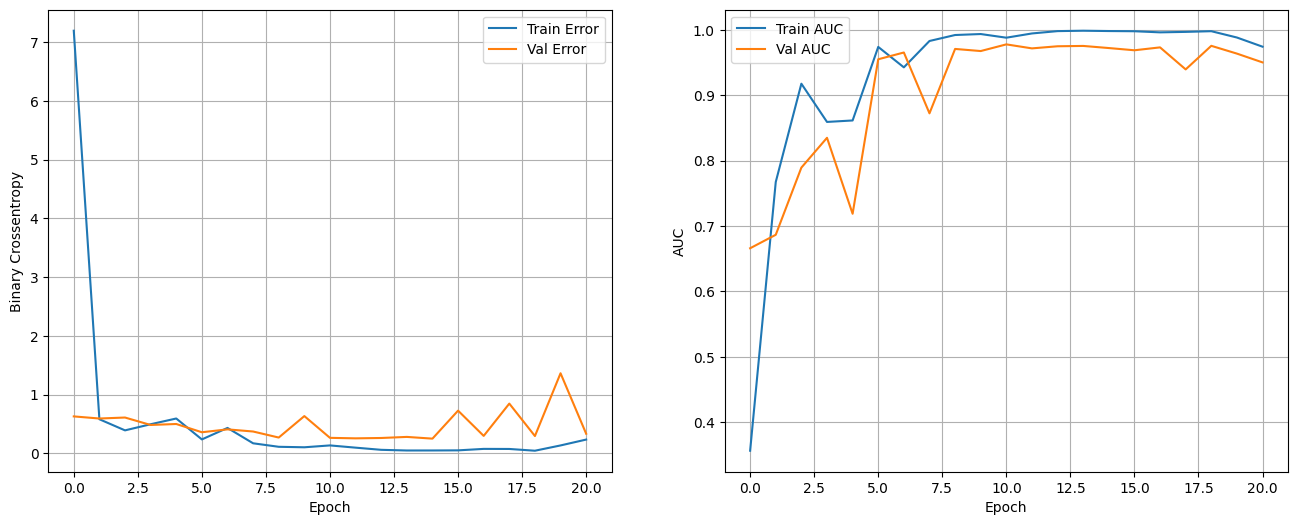

In [ ]:
def show_loss_auc_evolution(history):

    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Binary Crossentropy')
    ax1.plot(hist['epoch'], hist['loss'], label='Train Error')
    ax1.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    ax1.grid()
    ax1.legend()

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('AUC')
    ax2.plot(hist['epoch'], hist['auc'], label='Train AUC')
    ax2.plot(hist['epoch'], hist['val_auc'], label = 'Val AUC')
    ax2.grid()
    ax2.legend()

    plt.show()

show_loss_auc_evolution(history)

Insight de resultados

In [ ]:
true_labels = test_generator.labels
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
predictions = best_model.predict(test_generator)
preds = np.round(predictions).flatten()

3/3 [==============================] - 1s 147ms/step


Accuracy y AUC de sklearn

!! Ver que da distinta a la de TF. Es porque tienen configurados disitntos thresholds.

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

print(f'Accuracy en test: {accuracy_score(true_labels,preds)}')
print(f'AUC en test: {roc_auc_score(true_labels,preds)}')

Accuracy en test: 0.9178082191780822
AUC en test: 0.9041867954911433


Classification report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(true_labels,preds))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88        27
           1       0.92      0.96      0.94        46

    accuracy                           0.92        73
   macro avg       0.92      0.90      0.91        73
weighted avg       0.92      0.92      0.92        73



Matriz de confusion

In [ ]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)

Confusion matrix, without normalization
[[23  4]
 [ 2 44]]


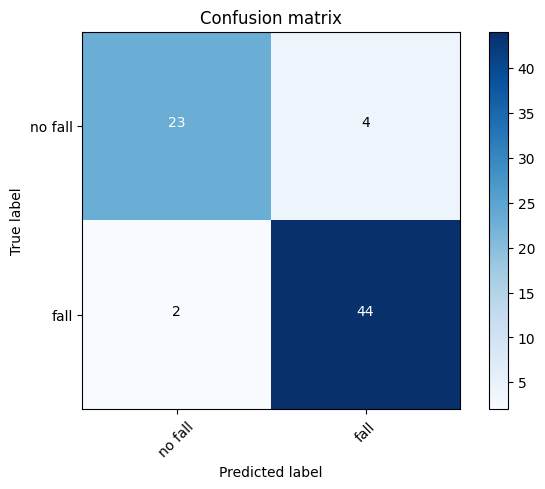

In [ ]:
class_names = list(test_generator.class_indices.keys())
plot_confusion_matrix(confusion_matrix(true_labels,preds),class_names)
plt.show()

## Ejemplos de errores

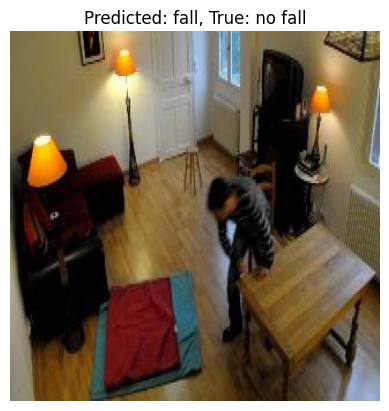

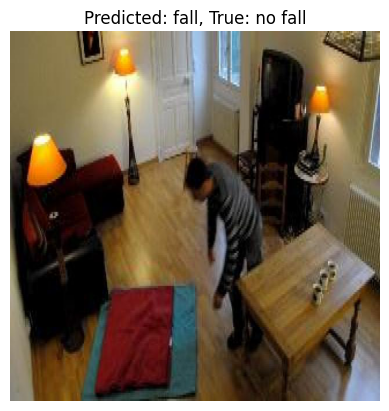

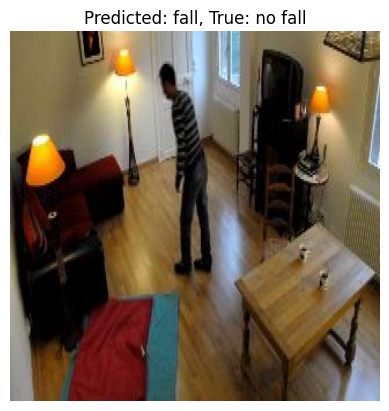

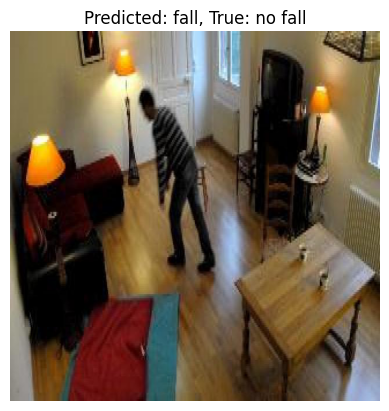

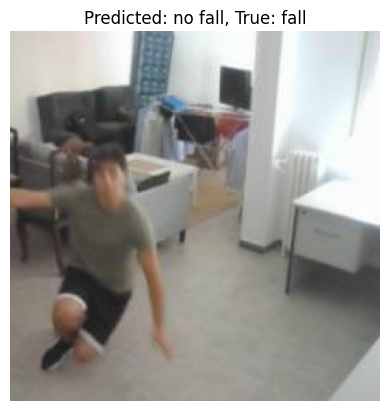

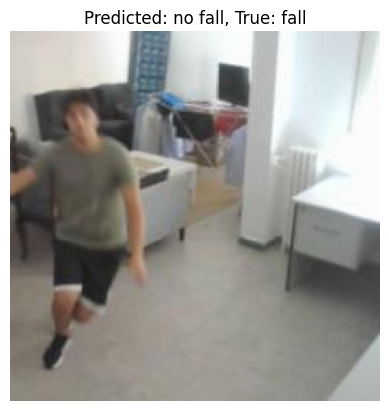

In [ ]:
# Recorre las imágenes de prueba y muestra cada una con su predicción y etiqueta real
for i in range(len(test_generator.filenames)):

    if class_names[int(preds[i])] != class_names[true_labels[i]]:

      image_path = test_dir + '/' + test_generator.filenames[i]
      image = plt.imread(image_path)

      plt.imshow(image)
      plt.title(f'Predicted: {class_names[int(preds[i])]}, True: {class_names[true_labels[i]]}')
      plt.axis('off')
      plt.show()

    else:
      pass

## Probando en nuevas imagenes

In [ ]:
def preprocessImage(image, target_size):
  resized_image = cv2.resize(image, target_size)
  normalized_image = resized_image.astype(np.float32) / 255.0
  return normalized_image

def predictNewImage(image, threshold=0.5):
  image_processed = preprocessImage(image, target_size=(224,224))
  prediction_example = best_model.predict(np.expand_dims(image_processed, axis=0))

  # Set a threshold for classifying as positive or negative
  threshold = 0.5

  # Convert the predicted probabilities to binary classes
  binary_preds = (prediction_example > threshold).astype(int)

  # Print the predicted class
  if binary_preds[0][0] == 1:
      print("The image is classified as Fall")
  else:
      print("The image is classified as No Fall")

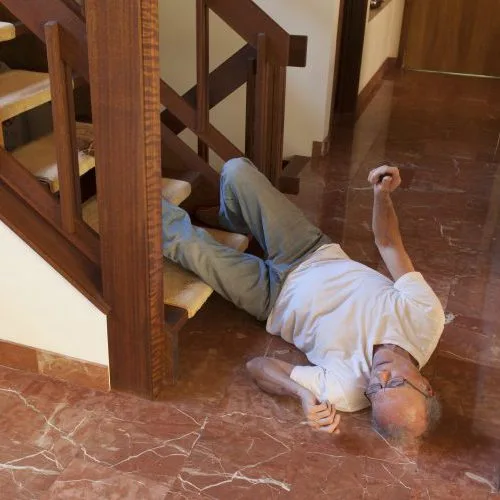

In [ ]:
img_path = '/content/example_2.jpg'
image = cv2.imread(img_path)
cv2_imshow(image)

In [ ]:
predictNewImage(image)

1/1 [==============================] - 0s 21ms/step
The image is classified as Fall


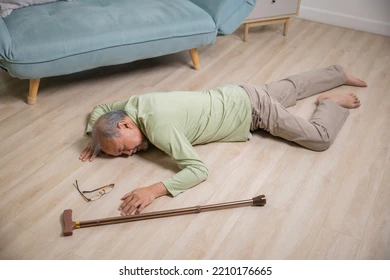

In [ ]:
img_path = '/content/example_3.jpg'
image = cv2.imread(img_path)
cv2_imshow(image)

In [ ]:
predictNewImage(image)

1/1 [==============================] - 0s 36ms/step
The image is classified as Fall


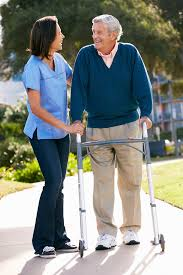

In [ ]:
img_path = '/content/example_no_fall.jpg'
image = cv2.imread(img_path)
cv2_imshow(image)

In [ ]:
predictNewImage(image)

1/1 [==============================] - 0s 24ms/step
The image is classified as No Fall


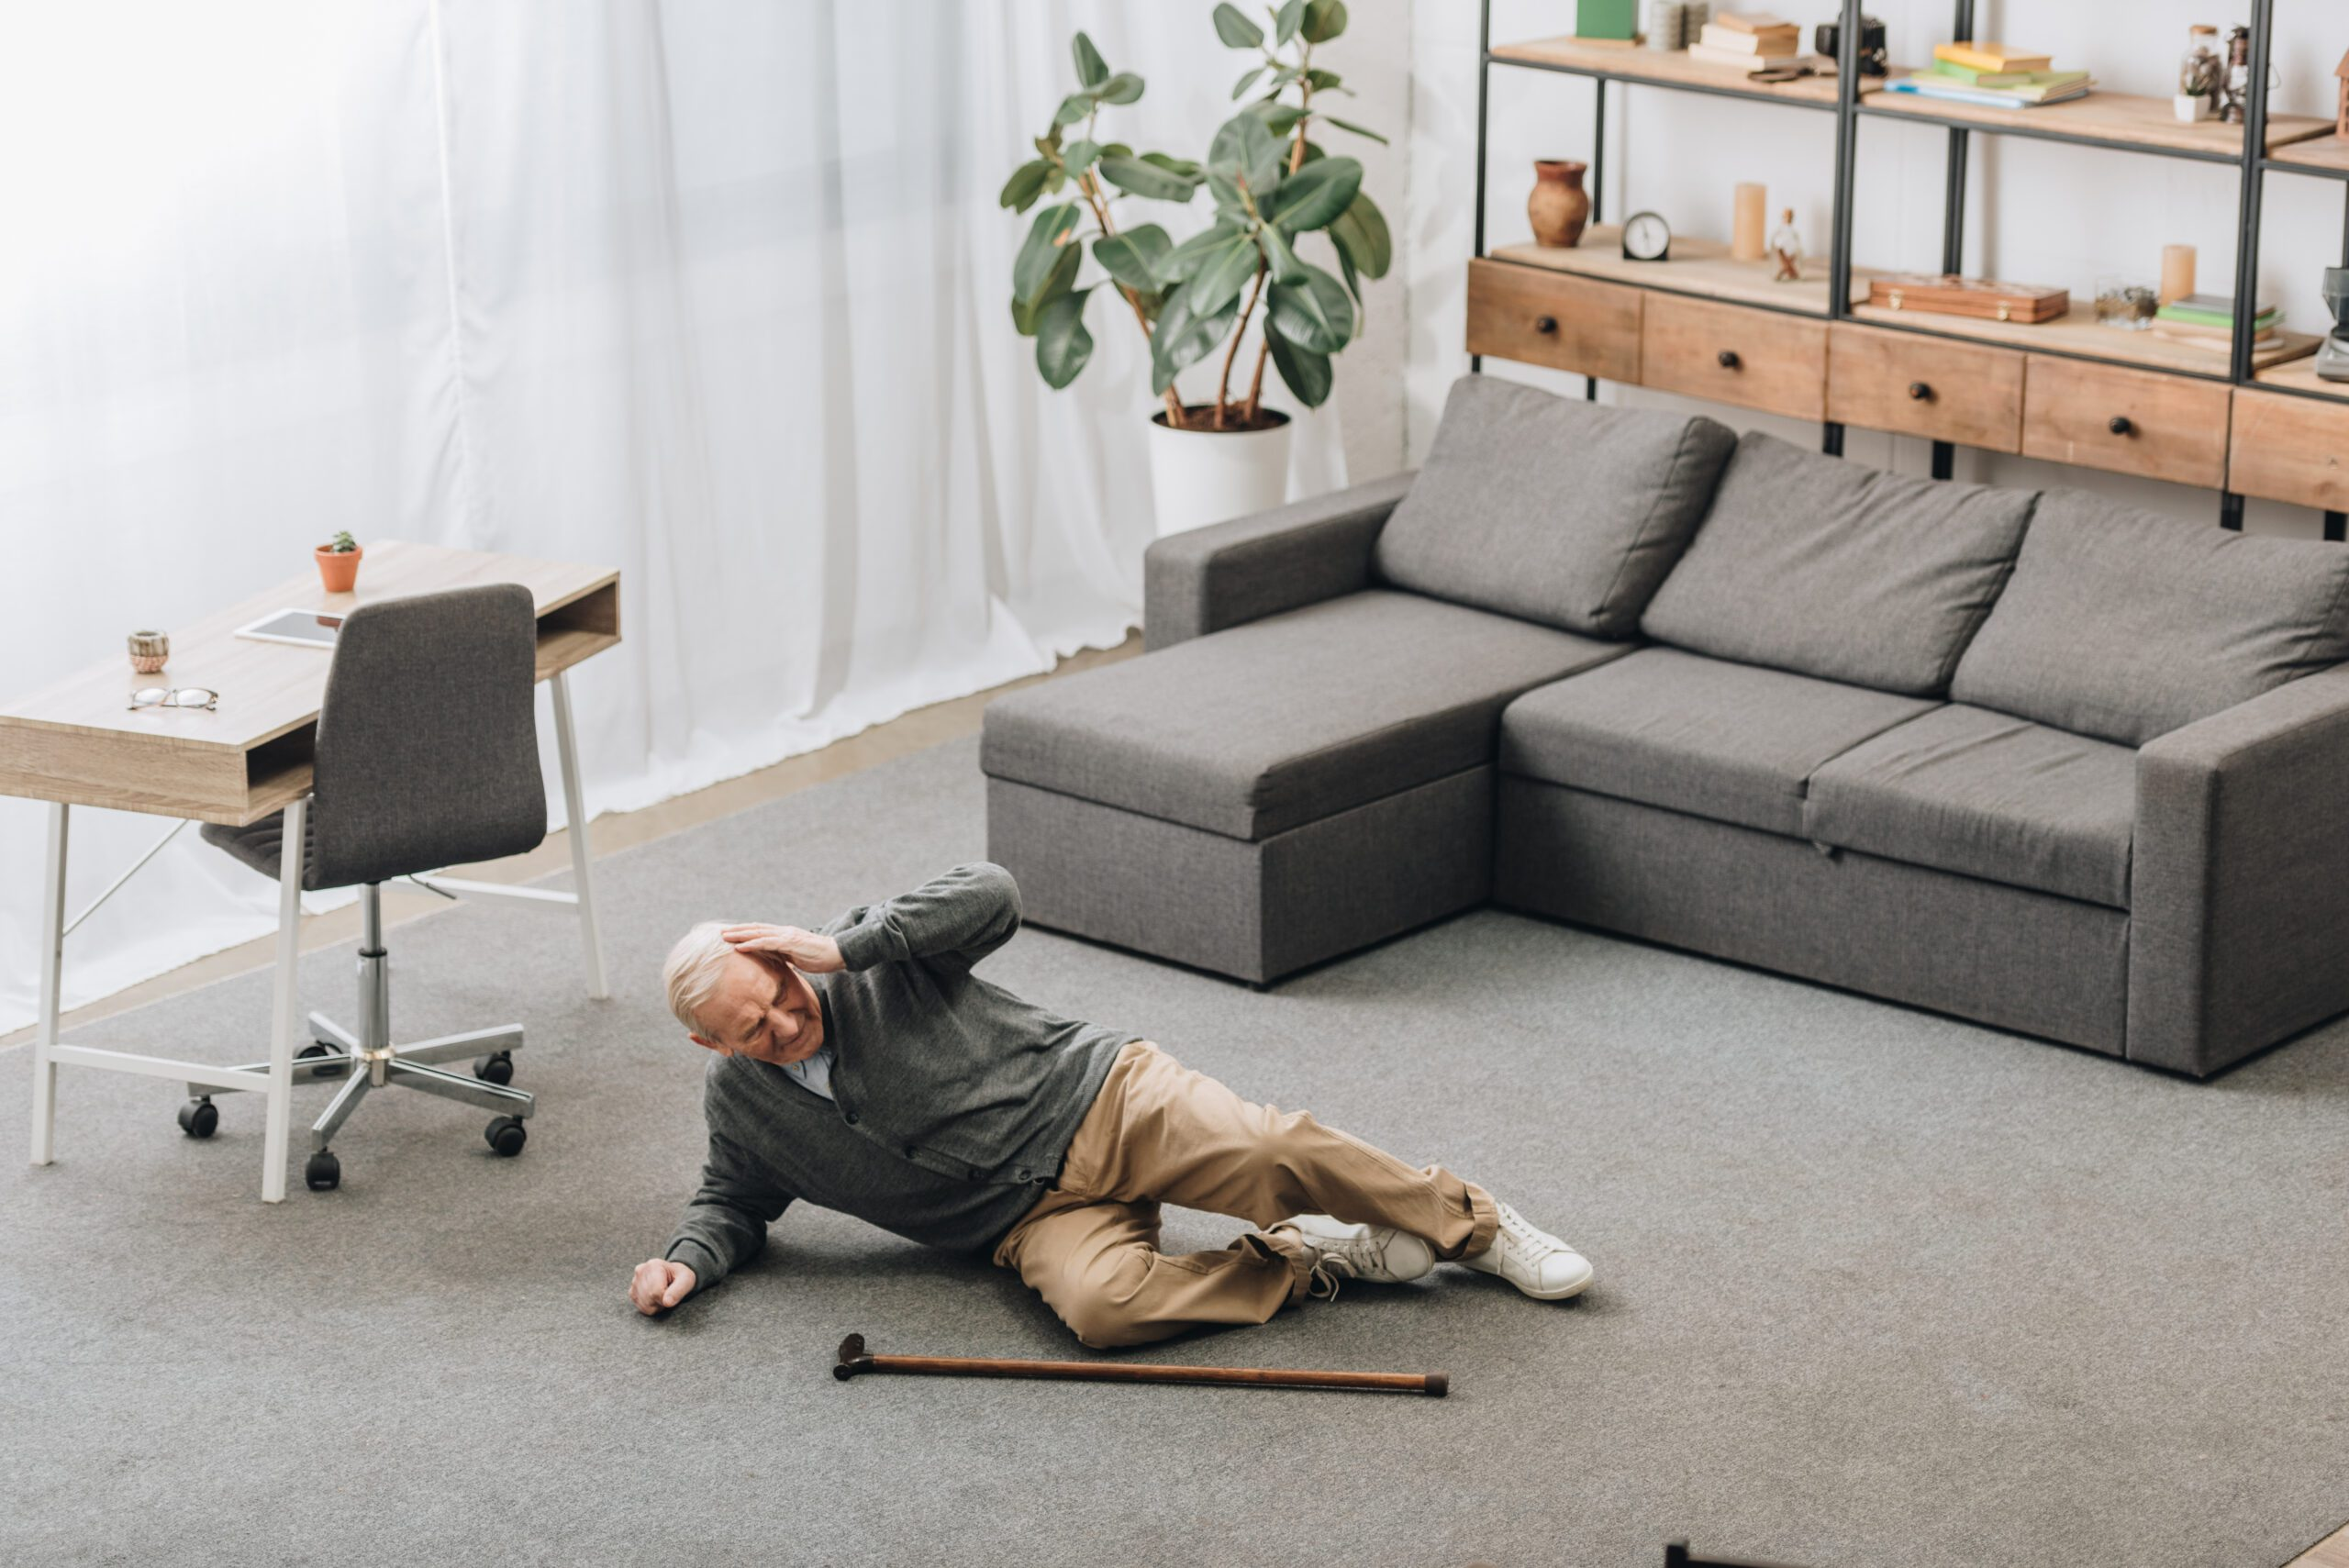

In [ ]:
img_path = '/content/example_fall.jpeg'
image = cv2.imread(img_path)
cv2_imshow(image)

In [ ]:
predictNewImage(image)

1/1 [==============================] - 0s 41ms/step
The image is classified as Fall


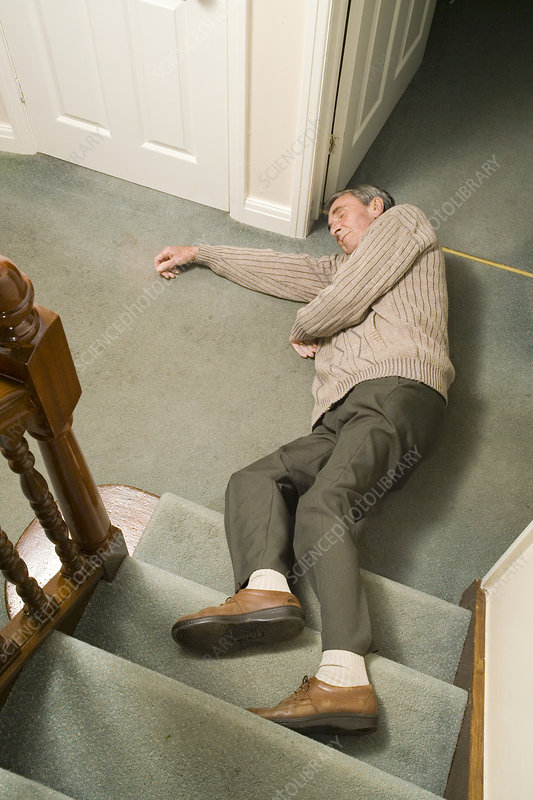

In [ ]:
img_path = '/content/example_1.jpg'
image = cv2.imread(img_path)
cv2_imshow(image)

In [ ]:
predictNewImage(image)

1/1 [==============================] - 0s 22ms/step
The image is classified as No Fall
